In [1]:
# 📥 1. Imports and Load Data
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, GPT2LMHeadModel, GPT2Tokenizer
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import wandb
import os

os.environ["WANDB_API_KEY"] = "e3facbc53138b2f4cbe5e555094d03d6a777d916"


/Users/beratburakkaya/Documents/iot_timeseries_machine_learning_updated/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# ⚙️ Use MPS if available (macOS), else fallback to CUDA/CPU
device = (
    torch.device("mps") if torch.backends.mps.is_available()
    else torch.device("cuda" if torch.cuda.is_available() else "cpu")
)
print("Using:", device)

# 🚀 Start WandB Run
wandb.init(
    project="llm_forecasting", 
    name="llm_eval_comparison",
    config={
        "model_name": "gpt2",
        "num_train_epochs": 5,
        "per_device_train_batch_size": 8,
        "per_device_eval_batch_size": 8,
        "save_steps": 500,
        "logging_steps": 500,
        "weight_decay": 0.01,
        "save_total_limit": 2,
        "learning_rate": 5e-5,
        "fp16": torch.cuda.is_available(),
        "report_to": "none",
    }
)

Using: mps


wandb: Currently logged in as: 24832901044 (24832901044-gazi-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [3]:
# 📊 Load the VAL dataset from preprocessed LLM files
df = pd.read_csv("../data/llm_preprocessed/val.csv")
df.head()


,prompt,completion
0,"Given past values: [0.1573062863677942, 0.1530...",[0.1741569682391246]
1,"Given past values: [0.1530936170899839, 0.1573...",[0.1657316296835039]
2,"Given past values: [0.1573062863677942, 0.1530...",[0.1629165225470376]
3,"Given past values: [0.1530936170899839, 0.1474...",[0.1587038532692272]
4,"Given past values: [0.1474634123372292, 0.1544...",[0.1601014201706602]


In [4]:
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return 100 * np.mean(diff)


In [5]:
# 🔄 Function to forecast using any LLM model
def forecast_llm(model, tokenizer, prompts):
    preds = []
    for prompt in prompts:
        inputs = tokenizer(prompt, return_tensors="pt", truncation=True).to(device)
        output = model.generate(
            **inputs,
            max_length=inputs["input_ids"].shape[1] + 10,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id,
        )
        generated = tokenizer.decode(output[0])
        try:
            pred_text = generated[len(prompt):].strip().split()[0]
            pred_value = float(pred_text.replace("[", "").replace("]", "").replace(",", ""))
        except:
            pred_value = 0.0  # fallback in case of messy output
        preds.append(pred_value)
    return preds

In [6]:
# 🎯 Target values (parsed safely)
def parse_targets(target_strs):
    return [float(eval(val)[0]) for val in target_strs]  # each target is a list with 1 float


In [7]:
val_prompts = df["prompt"].tolist()
val_targets = parse_targets(df["completion"].tolist())

In [8]:
# 🤖 Load NON-finetuned GPT2
print("\n🔍 Loading GPT2 base model...")
base_tokenizer = AutoTokenizer.from_pretrained("gpt2")
base_model = AutoModelForCausalLM.from_pretrained("gpt2").to(device)
base_preds = forecast_llm(base_model, base_tokenizer, val_prompts)

# 🤖 Load FINETUNED LLM Forecaster
print("\n🔍 Loading finetuned model...")
finetuned_tokenizer = GPT2Tokenizer.from_pretrained("../models/llm_forecaster/")
finetuned_model = GPT2LMHeadModel.from_pretrained("../models/llm_forecaster/").to(device)
finetuned_preds = forecast_llm(finetuned_model, finetuned_tokenizer, val_prompts)


🔍 Loading GPT2 base model...

🔍 Loading finetuned model...


In [9]:
# 📈 Evaluation
def evaluate(name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    smape_val = smape(np.array(y_true), np.array(y_pred))
    print(f"\n📊 {name} Results:")
    print(f"MSE   : {mse:.6f}")
    print(f"MAE   : {mae:.6f}")
    print(f"SMAPE : {smape_val:.2f}%")


    wandb.log({
        f"{name}/MSE": mse,
        f"{name}/MAE": mae,
        f"{name}/SMAPE": smape_val,
    })
    
    return mse, mae, smape_val

In [10]:
# Evaluate both

evaluate("Non-finetuned GPT2", val_targets, base_preds)
evaluate("Finetuned LLM Forecaster", val_targets, finetuned_preds)


📊 Non-finetuned GPT2 Results:
MSE   : 0.001605
MAE   : 0.029504
SMAPE : 16.71%

📊 Finetuned LLM Forecaster Results:
MSE   : 0.000237
MAE   : 0.011138
SMAPE : 6.42%


(0.0002372756188163134, 0.011137743578465949, np.float64(6.418210829079213))

/var/folders/s8/pp3cmgsj1h3gqdc1dpxr6yzm0000gn/T/ipykernel_47226/3798366814.py:9: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/s8/pp3cmgsj1h3gqdc1dpxr6yzm0000gn/T/ipykernel_47226/3798366814.py:12: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  plt.savefig(plot_path)
/Users/beratburakkaya/Documents/iot_timeseries_machine_learning_updated/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


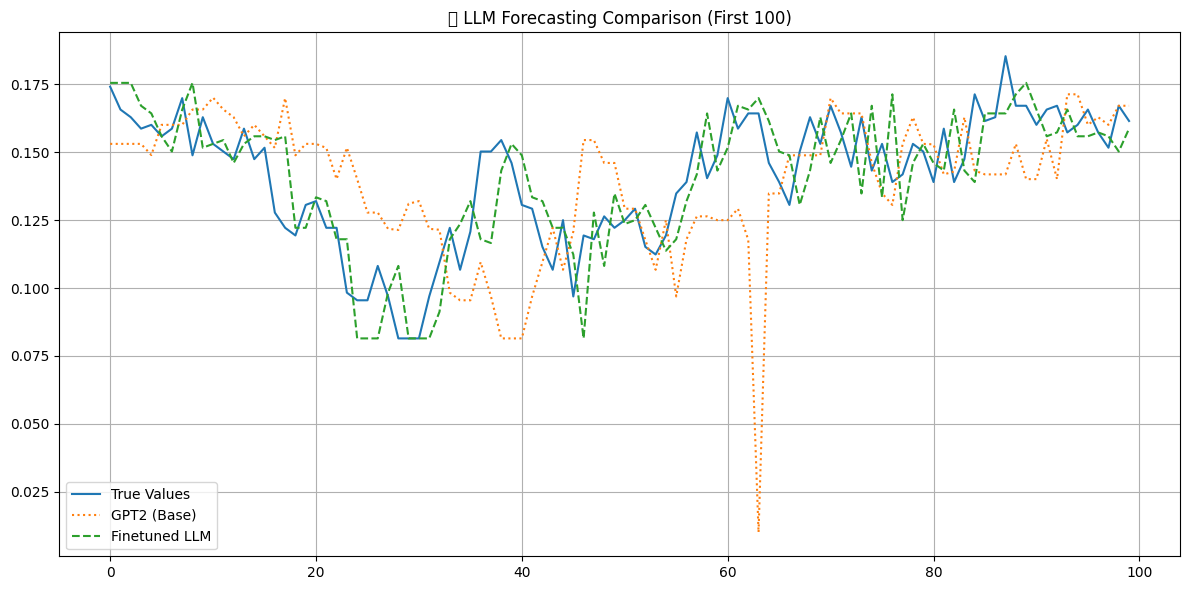

wandb: ERROR The nbformat package was not found. It is required to save notebook history.



✅ Comparison results saved to CSV and PNG


Finetuned LLM Forecaster/MAE,▁
Finetuned LLM Forecaster/MSE,▁
Finetuned LLM Forecaster/SMAPE,▁
Non-finetuned GPT2/MAE,▁
Non-finetuned GPT2/MSE,▁
Non-finetuned GPT2/SMAPE,▁
Finetuned LLM Forecaster/MAE,0.01114
Finetuned LLM Forecaster/MSE,0.00024
Finetuned LLM Forecaster/SMAPE,6.41821
Non-finetuned GPT2/MAE,0.0295
Non-finetuned GPT2/MSE,0.0016


In [11]:
# 📉 Plot first 100 predictions
plt.figure(figsize=(12, 6))
plt.plot(val_targets[:100], label="True Values")
plt.plot(base_preds[:100], label="GPT2 (Base)", linestyle="dotted")
plt.plot(finetuned_preds[:100], label="Finetuned LLM", linestyle="dashed")
plt.title("🔮 LLM Forecasting Comparison (First 100)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plot_path = "../../outputs/metrics/llm/llm_forecaster_comparison.png"
os.makedirs(os.path.dirname(plot_path), exist_ok=True)
plt.savefig(plot_path)
wandb.log({"forecast_plot": wandb.Image(plot_path)})
plt.show()

# ✅ Save results
results_df = pd.DataFrame({
    "True": val_targets,
    "GPT2_Pred": base_preds,
    "LLM_Finetuned_Pred": finetuned_preds
})
results_df.to_csv("../../outputs/metrics/llm/llm_forecaster_comparison.csv", index=False)
print("\n✅ Comparison results saved to CSV and PNG")


# ✅ Finish WandB
wandb.finish()